<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# autoreload updated and newly installed packages
# without having to restart Jupyter kernel
%load_ext autoreload
%autoreload 2
# Some little interaction with matplotlib
%matplotlib inline
# Avoid using Jedi for faster autocomplete (tab)
%config Completer.use_jedi = False

# Significance of fatigue cycles depending on their frequency

In [2]:
# Backwards compatibility of the cluster_df function with python 3.8.X
from __future__ import annotations

# Standard imports
import ast
import copy
import datetime
import platform
import os
import sys
import time
from typing import List, Any
from collections import ChainMap, defaultdict

# Non-standard imports
from pandas.tseries.frequencies import to_offset
from pathlib import Path
try:
    from tqdm import tqdm
except ImportError:
    print("\33[33mInstall the \33[1m'tqdm'\33[22m module in your python"
          "environment using:\n\n\33[30m>>> "
          "\33[1m\33[34mpip \33[22m\33[30minstall \33[1m\33[32mtqdm\33[22m\n")
import matplotlib
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
import plotly.graph_objs as go

# py-fatigue import
import py_fatigue as pf
import py_fatigue.testing as test
# Paths of this tutorial and of the data
TUTORIAL_PATH = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(Path.home(), "Documents", "Work", "data")
if not TUTORIAL_PATH in sys.path:
    sys.path.append(TUTORIAL_PATH)
np.set_printoptions(threshold=sys.maxsize)

In [3]:
print(f"Platform: {platform.platform()}")
print(f"Python version: {sys.version}")
print(f"py-fatigue version: {pf.styling.TermColors.CBOLD}{pf.__version__}")

print(f"{pf.styling.TermColors.CWHITEBG}\
{pf.styling.TermColors.CBOLD}\
{pf.styling.TermColors.CBLUE}")
      
print(f"DATA_PATH = {DATA_PATH}")
print(f"TUTORIAL_PATH = {TUTORIAL_PATH}")

print(f"{pf.styling.TermColors.CEND}")

Platform: Linux-5.19.0-26-generic-x86_64-with-glibc2.35
Python version: 3.8.15 (default, Dec 22 2022, 15:11:48) 
[GCC 12.2.0]
py-fatigue version: 1.0.14

DATA_PATH = /home/pd/Documents/Work/data
TUTORIAL_PATH = /home/pd/Python/Packages/Github/py-fatigue



In [4]:
plt.rcParams["figure.figsize"] = (7, 3.5)
plt.rcParams["font.family"] = ["Garamond", "Sans-Serif"]
plt.rcParams["font.size"] = 13
plt.rcParams["lines.markersize"] = 3
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.which"] = "both"
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.color"] = "#888888"
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.minor.bottom"] = True
plt.rcParams["xtick.top"] = True
plt.rcParams["xtick.minor.top"] = True
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.labelbottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["ytick.minor.left"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["ytick.minor.right"] = True
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.labelleft"] = True
plt.rcParams["image.cmap"] = "Paired"
plt.rcParams['axes.prop_cycle'] = matplotlib.rcsetup.cycler(
    'color',
    ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9E9E9E']
)

## 1. Data handling

### Import the data from csv file

The following operations are run:

1. Read .csv file containing cyce-counts in the form of py-fatigue sparse json
2. Set 'timestamp' as index
3. Convert literal columns containing the json cycle-counts to python dictionaries

In [10]:
dict_df_dmg = defaultdict(pd.DataFrame)

In [ ]:
dict_df_dmg = dict()
for aggr, df_d in dict_df_agg.items():
    dict_df_dmg[aggr] = pf.cycle_count.utils.calc_aggregated_damage(df_d, sn)

In [28]:
start = time.time()
# 1
print(f"\33[36m1. Read \33[1m.csv\33[22m files into \33[1m df\33[22m\33[0m")
dict_df_dmg = defaultdict(pd.DataFrame)
for aggr in ["T", "D", "W", "M", "Q", "Y"]:
    for year in [2018, 2019, 2020]:
        df1 = pd.read_csv(os.path.join(DATA_PATH, f"df_dmg_{aggr}_{year}.csv"))
        dict_df_dmg[aggr] = pd.concat([dict_df_dmg[aggr], df1])
        
    dict_df_dmg[aggr] = dict_df_dmg[aggr].set_index(["sn_curve", "timestamp"])  # type: ignore
end = time.time()
print(f"\nElapsed time is {np.round(end-start, 0)}, s.")

1. Read .csv files into  df

Elapsed time is 1.0, s.


<div class="alert alert-block alert-warning">
<b> ⚠️ Fallback:</b> In case we mess up with the main dataframe (<tt>df</tt>) used for the subsequent analyses, we keep <tt>df_</tt> intact as a fallback.
</div>


In [ ]:
dict_df_dmg["M"].loc["m=[3.]"]

### Aggregation of damages into total damage

The goal is obtaining one damage per date offset string aggregation (e.g. `'W'`), per parameter (e.g. `CC_...`), per SN curve. Therefore, the damages, grouped by date offset string and SN curve, are aggregated using the `sum()`.

As above, the resulting damages are stored in a multi-index dataframe which contains the `'aggregate_by'` and `'sn_curve'` columns as indices, the cycle-counted parameters names as column names, and the final damages in the cells.

To access this multi-index dataframe, follow for example this logic:

```python
sn_curve_lookup = "m=[4.]"
df_multiindex.loc[sn_curve_lookup]
```



In [30]:
df_dmg_agg = pd.DataFrame()
for aggr, df_d in dict_df_dmg.items():
    
    df_1 = df_d.groupby(["sn_curve"]).agg("sum")
    df_1["aggregate_by"] = aggr
    df_dmg_agg = pd.concat([df_dmg_agg, df_1])
# df_dmg_agg = df_dmg_agg.transpose()
df_dmg_agg = df_dmg_agg.set_index([df_dmg_agg.index, "aggregate_by"])

### Damage normalization with respect to the total

The subdataframe (for fixed SN curve) containing the damages for each parameter and for each aggregation string is normalized with respect to the `'all'` row that containing the damages due to all the frequencies.

For this operation to give the correct results, the aggregation strings must be sorted in increasing time-range order. This operation has been performed in precedence.

- Show minor gridlines and show every 5-10% major
- Remove faulty sensors
- Specify that we also account for the residuals of the residuals as half cycles and that the "resolved residuals" result in both full and half cycles. This is the cause of the additional damage.

- For Marc: we were working exactly on this and to share the finished result. See for m=3 you have little influence of aggregations (coherent with the factor ~1.1), while m=5 there is a substantial effect of even monthly cycles. It is a site-dependent observation, but knowing the North Sea usual weather, this is a consistent result.

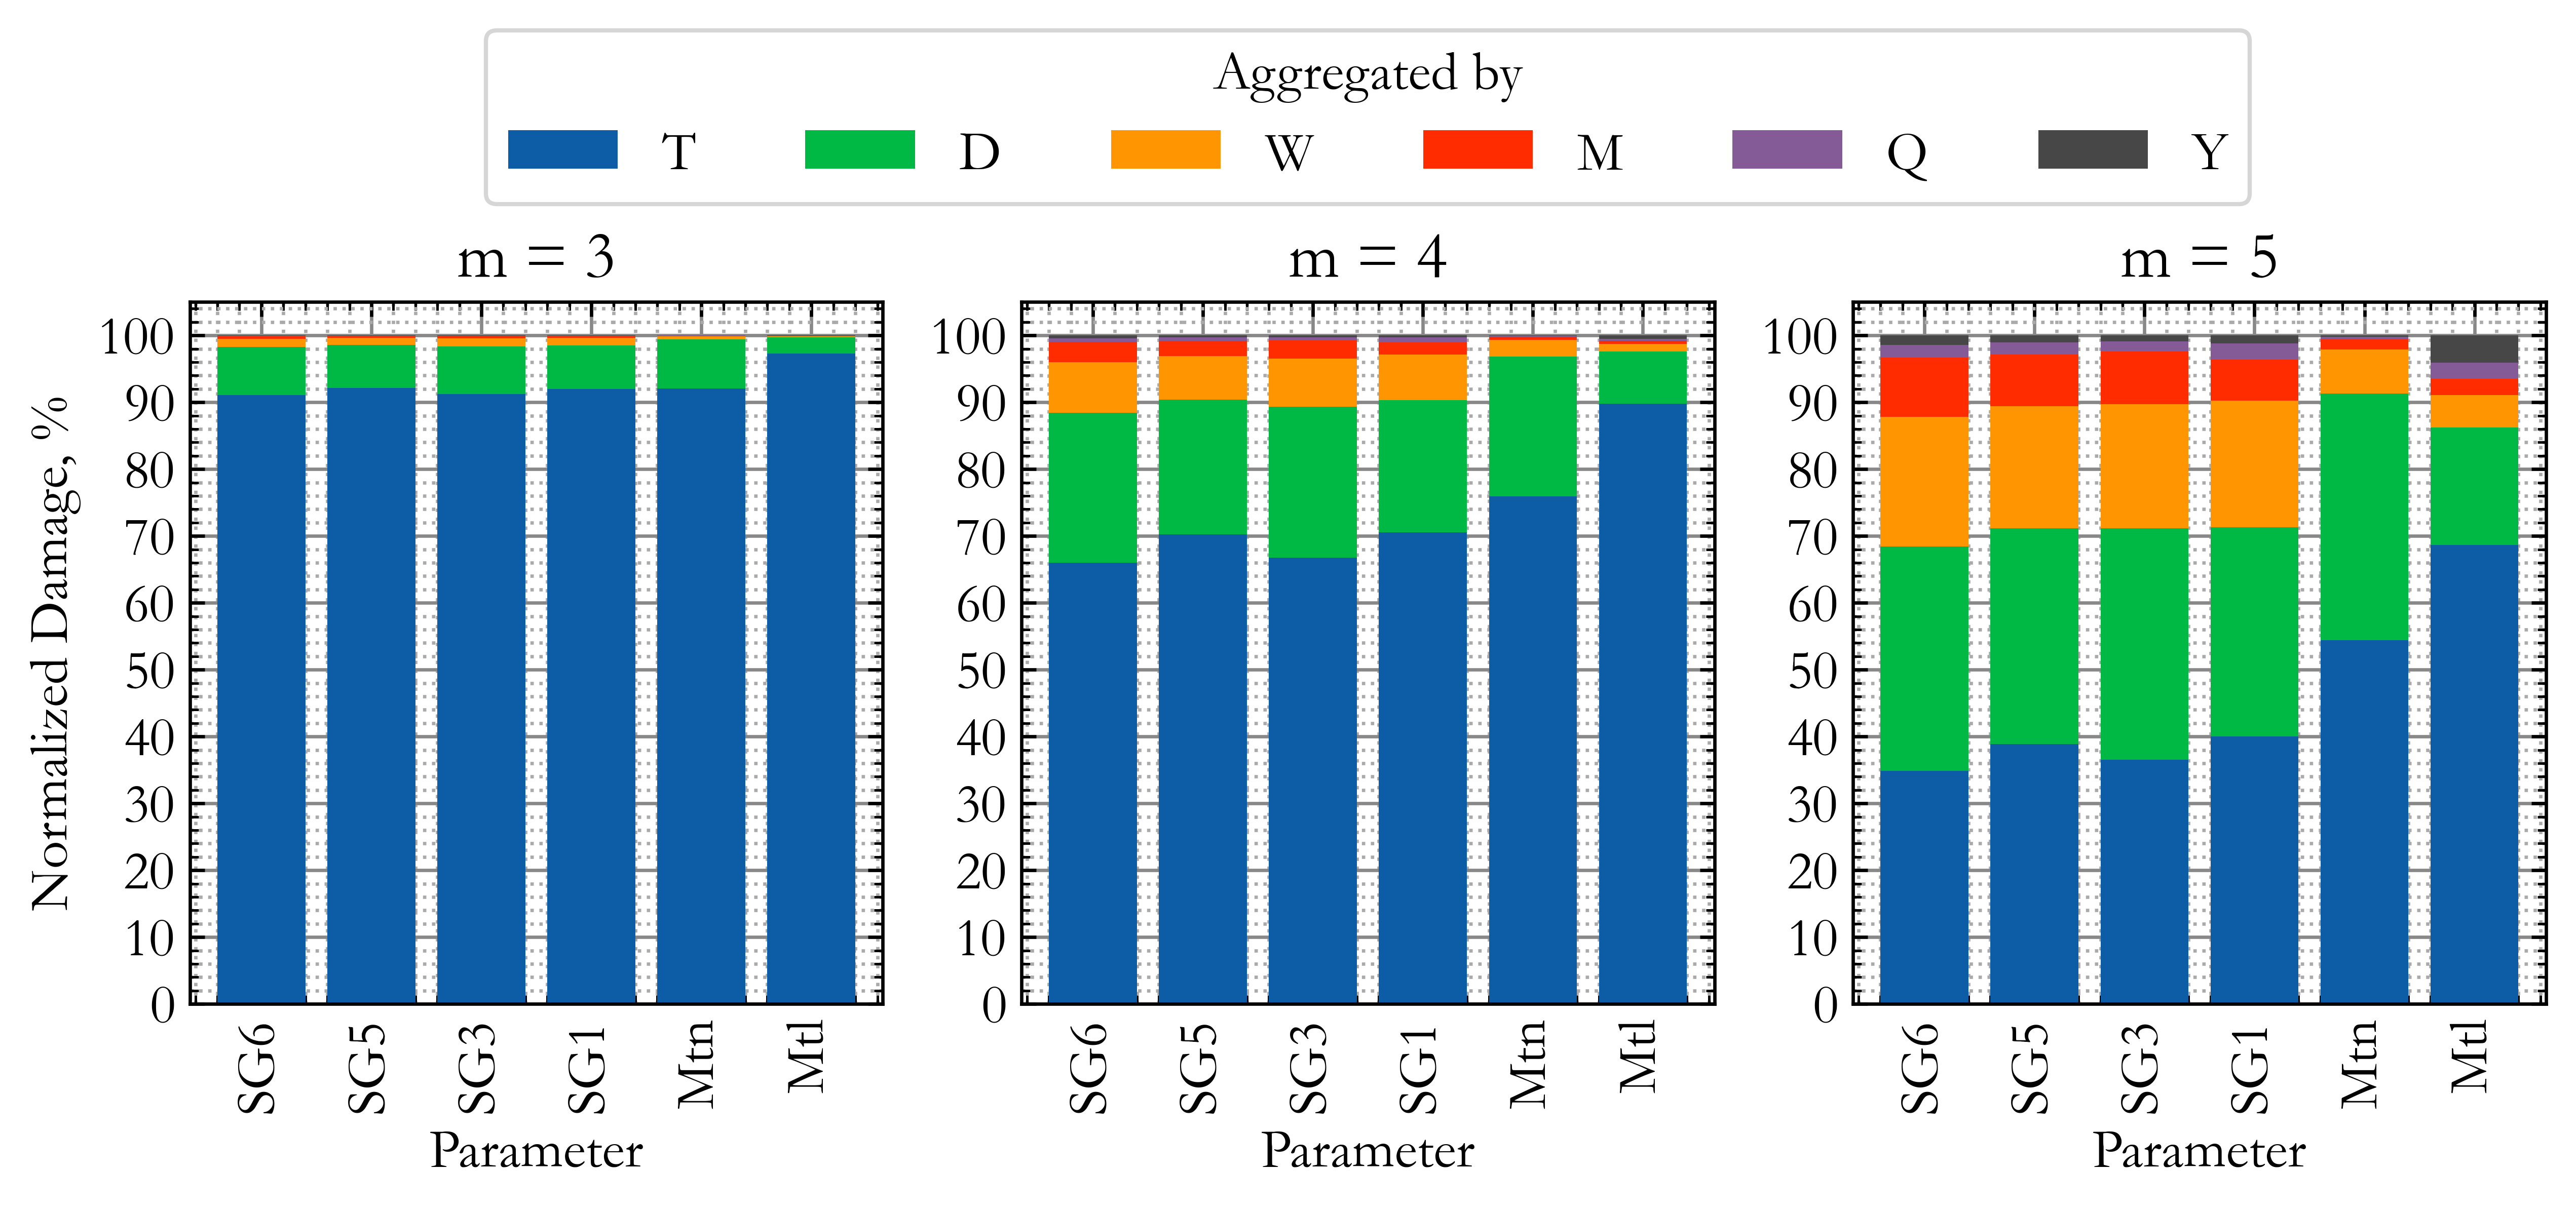

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=600)

for j, sn_key in enumerate(["m=[3.]", "m=[4.]", "m=[5.]"]):
    
    df_dmg_end = df_dmg_agg.loc[sn_key]
    df_norm = df_dmg_end.div(df_dmg_end.max())
    df_norm = pd.concat([df_norm.loc["T"].to_frame().T, df_norm.diff()[1:]],
                         ignore_index=True) * 100
    df_norm.index = df_dmg_end.index
    df_norm.columns = [name.split('_')[1] for name in df_norm.columns]
    df_norm.transpose().plot.bar(stacked=True, ax=axes[j], legend=False, width=0.8)
    axes
    axes[j].set_title(f"m = {sn_key[3]}")
    axes[j].set_yticks(np.linspace(0, 100, 11, dtype=int))
    axes[j].set_xlabel("Parameter")
    axes[j].minorticks_on()
    axes[j].grid(visible=True, which="minor", color="#AAAAAA", linestyle=":")
    if j == 0:
        axes[j].set_ylabel("Normalized Damage, %")
    if j == 1:
        axes[j].legend(title="Aggregated by", loc="lower center", fancybox=True,
                   bbox_to_anchor=(0.5, 1.1), ncol=6, shadow=False)